# AI-text-detector

Improve with following link:
* https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb#scrollTo=eXNLu_-nIrJI

In [44]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, XLMRobertaXLModel
import torch
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from tqdm import tqdm
import torch.optim as optim
import os
import pandas as pd


## Training

In [45]:
# load texts and labels
def text_edit(text):
    # remove first two lines
    text = '\n'.join(text.split('\n')[2:])
    return text

def load_data():

    # load our data
    data = {}

    data_sources = ['data/heste-nettet-nyheder/',
                   'data/from_big_data_file/',
                   'data/heste-nettet-nyheder-ai/gpt-3.5-turbo/', 
                    'data/heste-nettet-nyheder-ai/gpt-4-0613/', 
                    'data/from_big_data_file_ai/gpt-3.5-turbo/', 
                    'data/from_big_data_file_ai/gpt-3.5-turbo-0613/']
    counter = 0
    for path in data_sources:
        for filename in os.listdir(path):
            with open(path + filename, 'r', encoding='utf-8') as f:
                text = text_edit(f.read())
                data[counter] = {'text': text, 'source': path}
                counter += 1

    df = pd.DataFrame.from_dict(data, orient='index')
    df['ai_generated'] = df['source'].str.contains('ai')
    df['ai_generated'] = df['ai_generated'].astype(int)     

    df['val_data'] = 0

    # load validation data
    df_val = pd.read_csv('data/val.csv', index_col=0)
    # strings_val = df_val['0'].tolist()
    df_val['source'] = 'data/val.csv'
    df_val.rename(columns={'0': 'text'}, inplace=True)
    
    # label AI generated
    df_val['ai_generated'] = -1 # dont know
    df_val['val_data'] = 1


    # combine dataframes
    df = pd.concat([df, df_val], axis=0)
    # reset index
    df.reset_index(inplace=True, drop=True)

    return df

def selector(df):
    val_data = df[df['val_data'] == 1]
    val_labels = val_data['val_data'].tolist()
    val_texts = val_data['text'].tolist()

    train_data = df[df['val_data'] == 0]
    # shuffle
    train_data = train_data.sample(frac=1).reset_index(drop=True)
    extra_data = train_data[len(val_data):]
    train_data = train_data[:len(val_data)]
    
    train_labels = train_data['val_data'].tolist()
    train_texts = train_data['text'].tolist()

    texts = train_texts + val_texts
    labels = train_labels + val_labels

    return texts, labels, extra_data

def preprocess(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    return inputs

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.inputs = preprocess(texts)

        # dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
        self.input_ids = self.inputs['input_ids']
        self.attention_mask = self.inputs['attention_mask']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]

        return {
            # 'text': text,
            'label': label,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }


# Assume you're using a GPU for training
device = torch.device("mps" if torch.has_mps else "cpu")
print("Using device:", device)

###### SELECT MODEL ######
model_name = "bert-base-multilingual-cased"  # or another model suitable for Danish
tokenizer = BertTokenizer.from_pretrained(model_name, use_fast=True )
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

df = load_data()
texts, labels, extra_data = selector(df)

texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2)

dataset_train = TextDataset(texts_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

dataset_test = TextDataset(texts_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=True)


# print table summary with total samples in each dataset, positive samples, and negative samples
def pretty_print_info_table(labels_train, labels_test):
    data_for_table = {
        'train': {
            'total': len(labels_train),
            'pos': np.sum(labels_train),
            'neg': len(labels_train) - np.sum(labels_train)
        },
        'test': {
            'total': len(labels_test),
            'pos': np.sum(labels_test),
            'neg': len(labels_test) - np.sum(labels_test)
        }
    }
    data_for_table['total'] = {
        'total': data_for_table['train']['total'] + data_for_table['test']['total'],
        'pos': data_for_table['train']['pos'] + data_for_table['test']['pos'],
        'neg': data_for_table['train']['neg'] + data_for_table['test']['neg']
    }

    print("""
    Info table:
    +----------------+---------+---------+-------+
    |                | Training| Testing | Total
    +----------------+---------+---------+-------+
    | Total samples  | {:7d} | {:7d} | {:7d} |
    | Pos. samples   | {:7d} | {:7d} | {:7d} |  (AI generated)
    | Neg. samples   | {:7d} | {:7d} | {:7d} |  (Human written)
    """.format(
        data_for_table['train']['total'],
        data_for_table['test']['total'],
        data_for_table['total']['total'],
        data_for_table['train']['pos'],
        data_for_table['test']['pos'],
        data_for_table['total']['pos'],
        data_for_table['train']['neg'],
        data_for_table['test']['neg'],
        data_for_table['total']['neg'],
        
        ))

pretty_print_info_table(labels_train, labels_test)

Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



    Info table:
    +----------------+---------+---------+-------+
    |                | Training| Testing | Total
    +----------------+---------+---------+-------+
    | Total samples  |    1812 |     454 |    2266 |
    | Pos. samples   |     908 |     225 |    1133 |  (AI generated)
    | Neg. samples   |     904 |     229 |    1133 |  (Human written)
    


In [31]:

model.to(device)

# freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


# Training loop
from transformers import AdamW
lr = 1e-3*.4
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, )

# early stopping
def early_stopping(losses, patience=10):
    if len(losses) < patience:
        return False
    return losses[-1] > max(losses[-patience:-1])

losses = {'train': [], 'test': []}
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    # Train
    loss_total_train = 0
    for i, batch in enumerate(dataloader_train):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)


        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        #rint(outputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        loss_total_train += loss.item()

    print(f"Epoch {epoch} loss: {loss_total_train / len(dataset_train)}")
    losses['train'].append(loss_total_train / len(dataset_train))

    # Test
    model.eval()
    loss_total_test = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader_test):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss_total_test += loss.item()

    print(f"Epoch {epoch} test loss: {loss_total_test / len(dataset_test)}")
    losses['test'].append(loss_total_test / len(dataset_test))

    # if validation loss is lowest, save model
    if min(losses['test']) == losses['test'][-1]:
        model.save_pretrained("models/bert_article_classifier", save_function=torch.save)
        print("Model saved")

    if early_stopping(losses['test']):
        print("Early stopping")
        break


Epoch 0 loss: 0.03836238981280106
Epoch 0 test loss: 0.03207291242572179
Model saved
Epoch 1 loss: 0.03018691750946424
Epoch 1 test loss: 0.025877110955473608
Model saved


Text(0, 0.5, 'Loss')

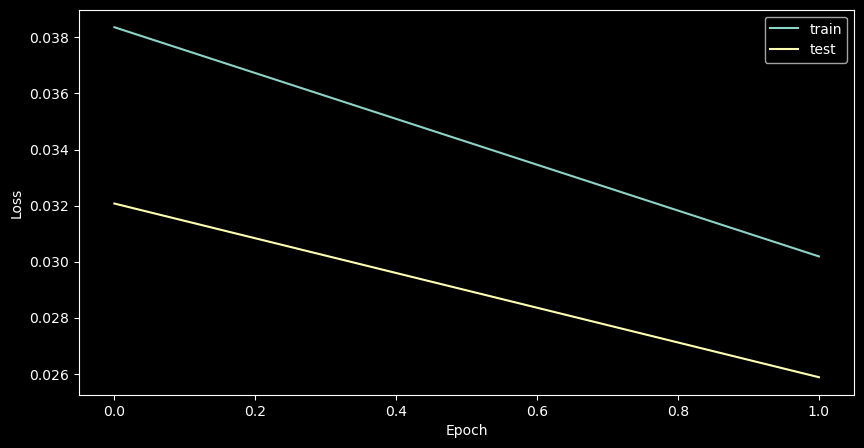

In [46]:
# load model
model = BertForSequenceClassification.from_pretrained("models/bert_article_classifier")
plt.style.use('dark_background')
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses['train'], label='train')
plt.plot(losses['test'], label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

## Model Application

In [59]:
# load my model
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("models/bert_article_classifier")
model.to(device);

100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


Text(0.5, 1.0, 'Confidence of prediction, positive is similar to validation data')

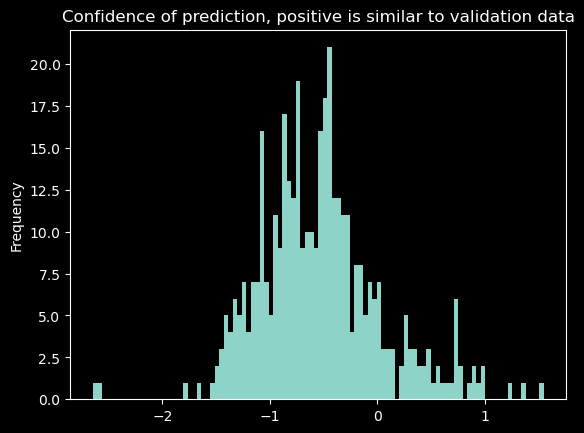

In [61]:
# predict strings_extras
texts_extra = extra_data['text'].tolist()
labels_extra = extra_data['ai_generated'].tolist()
from tqdm import tqdm
N = len(texts_extra)
dataset_apply = TextDataset(texts_extra[:N], labels_extra[:N])
dataloader_apply = DataLoader(dataset_apply, batch_size=80, shuffle=False)

# predict
model.eval()
predictions = []
with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader_apply), total=len(dataloader_apply)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = logits.cpu().numpy()
        predictions.append(pred)

predictions = np.concatenate(predictions, axis=0)
# put predictions in dataframe along with the strings
df_conf = pd.DataFrame({'text': texts_extra[:N], 
                        'ai_generated': labels_extra[:N],
                        'source': extra_data['source'].tolist()[:N],
                        'ours' : predictions[:, 0], 
                        'val': predictions[:, 1]})
df_conf['most confident'] = df_conf[['ours', 'val']].idxmax(axis=1)
df_conf['confidence'] =  df_conf['val'] - df_conf['ours']
df_conf['confidence'].plot.hist(bins=100)
plt.title("Confidence of prediction, positive is similar to validation data")

In [62]:
# show low confidence predictions and high confidence predictions
n = 3
print(f'The following {n} strings is very not similar to the validation data:')

for i in range(n):
    print(i+1)
    print(df_conf.sort_values('confidence').head(n)['text'].values[i])
    print()

print('#############################')
print(f'The following {n} string is very similar to the validation data:')
for i in range(n):
    print(i+1)
    print(df_conf.sort_values('confidence').tail(n)['text'].values[i])
    print()

The following 3 strings is very not similar to the validation data:
1
Robert for årets mandlige hovedrolle - Wikipedia, den frie encyklopædi
Robertprisen for årets mandlige hovedrolle er en filmpris, der siden 1984 er blevet uddelt af Danmarks Film Akademi ved den årlige Robertfest.
1984 – Jesper Klein for Skønheden og udyret
1985 – Lars Simonsen for Tro, håb og kærlighed
1989 – Börje Ahlstedt for Skyggen af Emma
1992 – Ole Lemmeke for De nøgne træer
1993 – Søren Østergaard for Kærlighedens smerte
1994 – Frits Helmuth for Det forsømte forår

2
Theodor Brorsen - Wikipedia, den frie encyklopædi
Fra Wikipedia, den frie encyklopædi
Uddannelse og virke
Theodor Johann Christian Ambders Brorsen (født 29. juli 1819 i Nordborg, død 31. marts 1895 sammesteds) var en dansk astronom.
5 Eksterne henvisninger
Theodor Brorsen blev født i Nordborg på Als som søn af kaptajn Christian August Brorsen (1793-1840) og hans kone Annette Margrethe Gerhardine Schumacher (1788-1855)

3
Sofja Kjoler - Wikipedia,

In [63]:
df_conf['ai_generated'].value_counts()

ai_generated
0    266
1    134
Name: count, dtype: int64

In [64]:
df_conf[df_conf['confidence'] > -.5]['ai_generated'].value_counts()

ai_generated
1    91
0    85
Name: count, dtype: int64

In [72]:
df_conf.to_csv('data/df_conf.csv')

In [73]:
df

,text,source,ai_generated,val_data
0,Ved det trestjernede CDI stævne I Wellington b...,data/heste-nettet-nyheder/,0,0
1,"Loven om hestehold skal revideres i 2012, og 8...",data/heste-nettet-nyheder/,0,0
2,Dansk Køre Selskab har fire kuske til VM i kør...,data/heste-nettet-nyheder/,0,0
3,Den fantastiske fuldblodshoppe Zenyatta som sk...,data/heste-nettet-nyheder/,0,0
4,Danmark har fire deltagere med ved VM for 1-sp...,data/heste-nettet-nyheder/,0,0
...,...,...,...,...
16659,"Ja, det er blevet rapporteret, at Rusland står...",data/val.csv,-1,1
16660,"Ja, der er tale om en domsmandssag, hvor der e...",data/val.csv,-1,1
16661,Vi er sociale liberale - det er ikke at man er...,data/val.csv,-1,1
16662,"I klubberne er der også fokus på præstation, o...",data/val.csv,-1,1


In [74]:
pd.read_csv('data/df_conf.csv', index_col=0)

,text,ai_generated,source,ours,val,most confident,confidence
0,Emnet handler om at vise de bedste tilbud på C...,1,data/from_big_data_file_ai/gpt-3.5-turbo-0613/,0.365618,-0.240335,ours,-0.605952
1,Når Reem Acra FEI World Cup om kort tid kommer...,0,data/heste-nettet-nyheder/,0.647488,-0.497855,ours,-1.145343
2,I dagens 1st Horse Cup i Intermediaire II for ...,0,data/heste-nettet-nyheder/,0.252598,-0.028346,ours,-0.280945
3,"Græssyge, forårsager stor lidelse for de heste...",0,data/heste-nettet-nyheder/,0.391066,-0.224690,ours,-0.615756
4,På denne side kan du finde nøgletal fra Verden...,0,data/from_big_data_file/,0.347054,-0.111799,ours,-0.458853
...,...,...,...,...,...,...,...
395,Den danske landsholdsrytter Camilla Enemark to...,0,data/heste-nettet-nyheder/,0.179080,-0.085621,ours,-0.264701
396,"Jeg elsker The Jam! Jeg synes, de var et fanta...",1,data/from_big_data_file_ai/gpt-3.5-turbo-0613/,-0.155959,0.304479,val,0.460437
397,Vejledningen til opsætning af hardware i PDF-f...,1,data/from_big_data_file_ai/gpt-3.5-turbo-0613/,-0.116189,0.296117,val,0.412306
398,"Frontier Ask er en ny fløjhingst, der har skab...",1,data/heste-nettet-nyheder-ai/gpt-3.5-turbo/,0.231384,-0.049223,ours,-0.280606
